# Deep GP samples

To help develop a more intuitive understanding of deep Gaussian processes, in this notebook we show how to generate a sample from the full deep GP, by propagating a sample through the layers.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import gpflow
from gpflux.helpers import construct_basic_kernel, construct_basic_inducing_variables
from gpflux.layers import GPLayer
from gpflux.experiment_support.plotting import plot_layer

tf.random.set_seed(42)

2024-06-20 12:01:05.022488: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-20 12:01:05.053090: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-20 12:01:05.053869: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-06-20 12:01:05.759201: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
num_data = 200
D = 1
a, b = 0, 1
X = np.linspace(a, b, num_data).reshape(-1, 1)

## Constructing the layers

Note that we give the `full_cov=True` argument to `GPLayer` so that we obtain correlated samples.
We give the last layer a `gpflow.mean_functions.Zero` mean function (the GPflux default is an Identity mean function).

In [3]:
num_samples = 5

In [4]:
Z = X.copy()
M = Z.shape[0]

# Layer 1
inducing_var1 = construct_basic_inducing_variables(M, D, D, share_variables=True, z_init=Z.copy())
kernel1 = construct_basic_kernel(
    gpflow.kernels.SquaredExponential(lengthscales=0.15),
    output_dim=D,
    share_hyperparams=True,
)
layer1 = GPLayer(kernel1, inducing_var1, num_data, full_cov=True, num_samples=num_samples)

# Layer 2
inducing_var2 = construct_basic_inducing_variables(M, D, D, share_variables=True, z_init=Z.copy())
kernel2 = construct_basic_kernel(
    gpflow.kernels.SquaredExponential(lengthscales=0.8, variance=0.1),
    output_dim=D,
    share_hyperparams=True,
)
layer2 = GPLayer(kernel2, inducing_var2, num_data, full_cov=True, num_samples=num_samples)

# Layer 3
inducing_var3 = construct_basic_inducing_variables(M, D, D, share_variables=True, z_init=Z.copy())
kernel3 = construct_basic_kernel(
    gpflow.kernels.SquaredExponential(lengthscales=0.3, variance=0.1),
    output_dim=D,
    share_hyperparams=True,
)
layer3 = GPLayer(
    kernel3,
    inducing_var3,
    num_data,
    full_cov=True,
    num_samples=num_samples,
    mean_function=gpflow.mean_functions.Zero(),
)

gp_layers = [layer1, layer2, layer3]

/home/runner/work/GPflux/GPflux/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(


## Propagating samples through the layers

In [5]:
layer_input = X

In [6]:
means, covs, samples = [], [], []

for layer in gp_layers:
    layer_output = layer(layer_input)

    mean = layer_output.mean()
    cov = layer_output.covariance()
    sample = tf.convert_to_tensor(layer_output)  # generates num_samples samples...

    layer_input = sample[0]  # for the next layer

    means.append(mean.numpy().T)  # transpose to go from [1, N] to [N, 1]
    covs.append(cov.numpy())
    samples.append(sample.numpy())

## Visualising samples

From top to bottom we plot the input to a layer, the covariance of outputs of that layer, and samples from the layer's output.

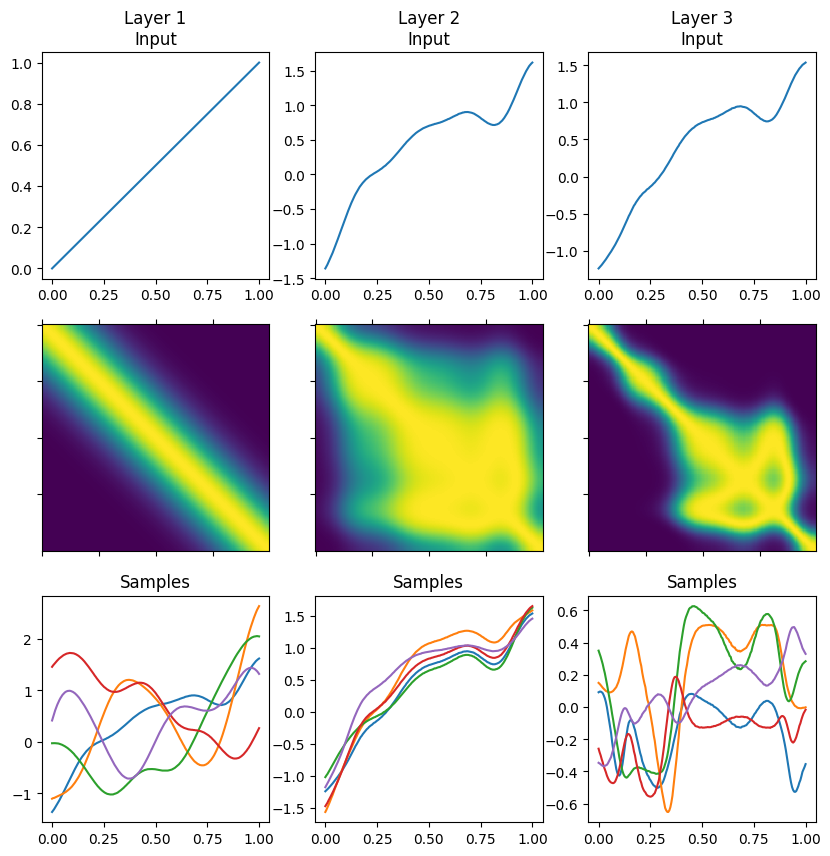

In [7]:
num_layers = len(gp_layers)
fig, axes = plt.subplots(3, num_layers, figsize=(num_layers * 3.33, 10))

for i in range(num_layers):
    layer_input = X if i == 0 else samples[i - 1][0]
    plot_layer(X, layer_input, means[i], covs[i], samples[i], i, axes[:, i])